In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

ha


In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [4]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [8]:
hits_tot = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_norm = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_shift = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

dt=10*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate(mod_names):
    for j in range(2):
        simm=sims[mod][j]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.46*u.s)[0][0]
        
        data=hits[id5:id6]
        hits_tot[mod].append(data) 
        
        s=np.sum(data)
        m=np.max(data)
        ta=data[np.where(t[id5:id6]==.4*u.s)[0][0]]
        norm_hits_sum=data/s
        
        hits_norm[mod].append(norm_hits_sum) 


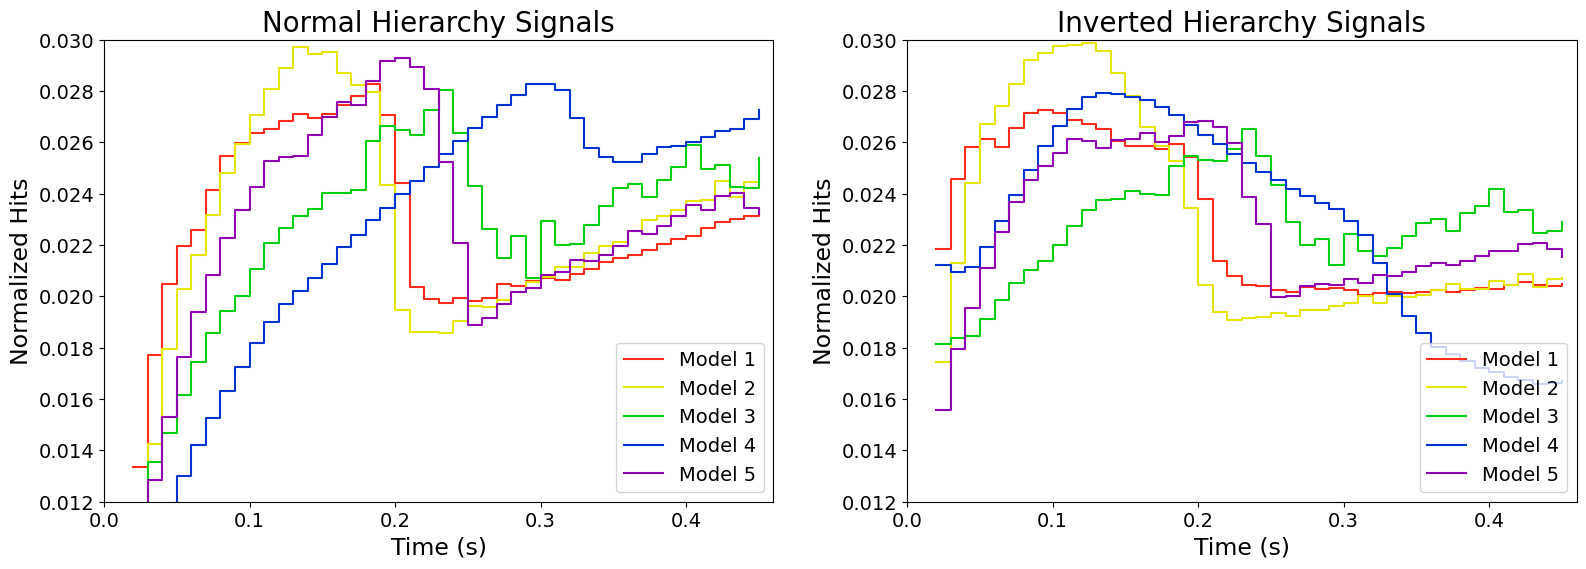

In [9]:
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
colors_imo=['#fc968b','#faf1b1','#7ffc72','#91aafa','#e88bfc']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']
mod_labs=['Model 1','Model 2','Model 3','Model 4','Model 5']


fig, axes = plt.subplots(1, 2, figsize=(19, 6))
axes = axes.flatten()
for i,mod in enumerate(mod_names):
    axes[0].step(t[id5:id6], hits_norm[mod][0], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[0].legend(loc='lower right',fontsize=14)
axes[0].set_xlim(0,.46)
axes[0].set_ylim(.012,.03)
axes[0].set_xlabel('Time (s)',fontsize=17)
axes[0].set_ylabel('Normalized Hits',fontsize=17)
axes[0].set_title('Normal Hierarchy Signals',fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=14)

for i,mod in enumerate(mod_names):
    axes[1].step(t[id5:id6], hits_norm[mod][1], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[1].legend(loc='lower right',fontsize=14)
axes[1].set_xlim(0,.46)
axes[1].set_ylim(.012,.03)
axes[1].set_xlabel('Time (s)',fontsize=17)
axes[1].set_ylabel('Normalized Hits',fontsize=17)
axes[1].set_title('Inverted Hierarchy Signals',fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=14)
plt.savefig('norm_sig_indep.png', dpi=300, bbox_inches='tight')

In [6]:
ratios_nh=np.load('ratios_many_priors_nh.npz',allow_pickle=True)['arr_0']
ratios=np.load('ratios_many_priors_ih.npz',allow_pickle=True)['arr_0']
ratios=ratios.item()
ratios_nh=ratios_nh.item()

In [21]:
prior_list=np.linspace(.2,.99,100)
np.savez('ratios_many_priors_no_energy.npz',ratios_no_energy)
np.savez('ratios_many_priors_energy.npz',ratios_energy)
np.savez('prior_list.npz',prior_list)

In [20]:

prior_list=np.linspace(.2,.99,100)
names=['zha','sukh_sfho', 'sukh_sfho', 'forn', 'tamb']
labels=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
ratios_no_energy={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }

for i,mod_name in enumerate(names):
    if(ratios_nh[mod_name][0][0][0]<ratios[mod_name][0][0][0]):
        ratios_no_energy[labels[i]]=ratios_nh[mod_name][0][0]
    else:
        ratios_no_energy[labels[i]]=ratios[mod_name][0][0]
        
ratios_energy={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}
all_ratios_nh, all_ratios_ih = sigma_to_ratios(.5,prior_list)
names=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
for i,mod_name in enumerate(names):
    means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
    means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
    if(means_nh[0]<means_ih[0]):
        ratios_energy[mod_name]=means_nh
    else:
        ratios_energy[mod_name]=means_ih

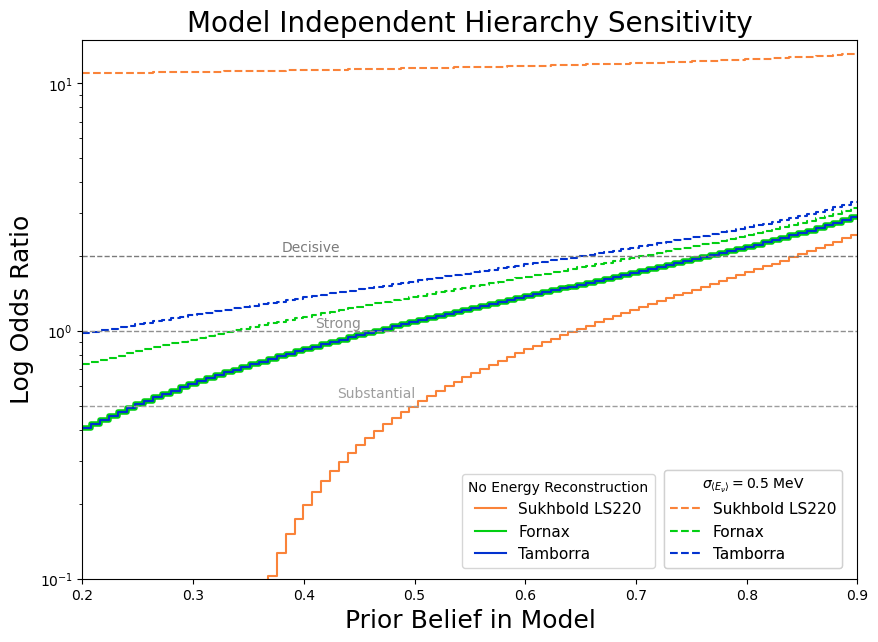

In [24]:
ratios_no_energy=np.load('ratios_many_priors_no_energy.npz',allow_pickle=True)['arr_0']
ratios_no_energy=ratios_no_energy.item()

ratios_energy=np.load('ratios_many_priors_energy.npz',allow_pickle=True)['arr_0']
ratios_energy=ratios_energy.item()

prior_list=np.load('prior_list.npz',allow_pickle=True)['arr_0']

plt.figure(figsize=(10,7))
colors=['#02cf13','#0232cf','#fa8339']
names=['forn','tamb','sukh_ls220']
labels=['Fornax', 'Tamborra', 'Sukhbold LS220']

for i,mod_name in enumerate(names):
    if(mod_name=='forn'):
        plt.step(prior_list,ratios_no_energy[mod_name],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i],lw=4)

    else:
        plt.step(prior_list,ratios_no_energy[mod_name],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])


for i,mod_name in enumerate(names):
    plt.step(prior_list,ratios_energy[mod_name],color=colors[i],where='post',label=labels[i],linestyle='--')
            
legend1_handles = [Line2D([0], [0], color='#fa8339', linestyle='-', label='Sukhbold LS220'),
                   Line2D([0], [0], color='#02cf13', linestyle='-', label='Fornax'),
                  Line2D([0], [0], color='#0232cf', linestyle='-', label='Tamborra')]

legend2_handles = [Line2D([0], [0], color='#fa8339', linestyle='--', label='Sukhbold LS220'),
                   Line2D([0], [0], color='#02cf13', linestyle='--', label='Fornax'),
                  Line2D([0], [0], color='#0232cf', linestyle='--', label='Tamborra')]

legend1 = plt.legend(handles=legend1_handles, loc=(.49,.02), ncol=1,title='No Energy Reconstruction',fontsize=11)
legend2 = plt.legend(handles=legend2_handles, loc=(.75,.02), ncol=1,title=r'$\sigma_{\langle E_\nu\rangle}=0.5$ MeV',fontsize=11)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
            

plt.title('Model Independent Hierarchy Sensitivity',fontsize=20)
plt.xlabel('Prior Belief in Model',fontsize=18)
plt.ylabel('Log Odds Ratio',fontsize=18)
plt.ylim(.1,15)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=10,color='#7B7B7B')
plt.text(.41,1.03,'Strong',fontsize=10,color='#8F8F8F')
plt.text(.43,.54,'Substantial',fontsize=10,color='#9E9E9E')
plt.yscale('log')
plt.savefig('norm_sig_indep.png', dpi=300, bbox_inches='tight')

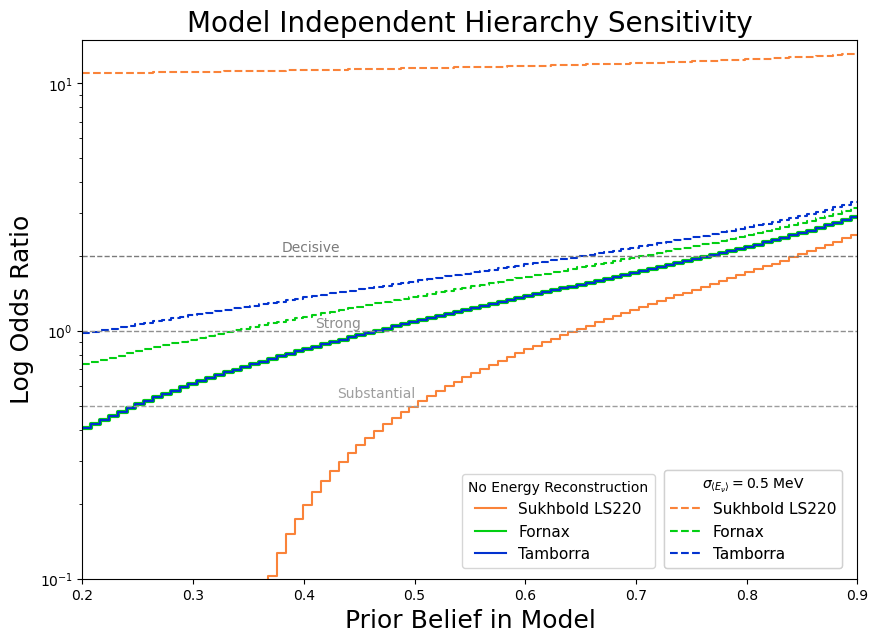

In [14]:
from matplotlib.lines import Line2D
plt.figure(figsize=(10,7))
prior_list=np.linspace(.2,.99,100)
colors=['#9200b3','#02cf13','#0232cf','#fa8339']
names=['zha','forn','tamb','sukh_sfho']
labels=['zha', 'Fornax', 'Tamborra', 'Sukhbold LS220']
linestyles=['-','-','-','-','-']

for i,mod_name in enumerate(names):
    if(mod_name=='forn'):
        if(ratios_nh[mod_name][0][0][0]<ratios[mod_name][0][0][0]):
            plt.step(prior_list,np.array(ratios_nh[mod_name][0][0]),color=colors[i],where='post',label=labels[i],linestyle=linestyles[i],lw=3)
        else:
            plt.step(prior_list,np.array(ratios[mod_name][0][0]),color=colors[i],where='post',label=labels[i],linestyle=linestyles[i],lw=3)
    elif(mod_name!='zha'):
        if(ratios_nh[mod_name][0][0][0]<ratios[mod_name][0][0][0]):
            plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
        else:
            plt.step(prior_list,ratios[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])

colors=['#9200b3','#fcba03','#fa8339','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
labels=['Zha','Sukhbold SFHo','Sukhbold LS220','Fornax','Tamborra']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}
all_ratios_nh, all_ratios_ih = sigma_to_ratios(.5,prior_list=prior_list)

for i,mod_name in enumerate(names):
    if(mod_name!='zha' and mod_name != 'sukh_sfho'):
        means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
        means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
        if(means_nh[0]<means_ih[0]):
            plt.step(prior_list,means_nh,color=colors[i],where='post',label=labels[i],linestyle='--')
            ratio_mins[mod_name]=means_nh
        else:
            plt.step(prior_list,means_ih,color=colors[i],where='post',label=labels[i],linestyle='--')
            ratio_mins[mod_name]=means_ih
            
legend1_handles = [Line2D([0], [0], color='#fa8339', linestyle='-', label='Sukhbold LS220'),
                   Line2D([0], [0], color='#02cf13', linestyle='-', label='Fornax'),
                  Line2D([0], [0], color='#0232cf', linestyle='-', label='Tamborra')]

legend2_handles = [Line2D([0], [0], color='#fa8339', linestyle='--', label='Sukhbold LS220'),
                   Line2D([0], [0], color='#02cf13', linestyle='--', label='Fornax'),
                  Line2D([0], [0], color='#0232cf', linestyle='--', label='Tamborra')]

legend1 = plt.legend(handles=legend1_handles, loc=(.49,.02), ncol=1,title='No Energy Reconstruction',fontsize=11)
legend2 = plt.legend(handles=legend2_handles, loc=(.75,.02), ncol=1,title=r'$\sigma_{\langle E_\nu\rangle}=0.5$ MeV',fontsize=11)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
            
            
#plt.legend(loc='upper right')
#plt.legend(loc='upper right')
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity',fontsize=20)
plt.xlabel('Prior Belief in Model',fontsize=18)
plt.ylabel('Log Odds Ratio',fontsize=18)
plt.ylim(.1,15)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=10,color='#7B7B7B')
plt.text(.41,1.03,'Strong',fontsize=10,color='#8F8F8F')
plt.text(.43,.54,'Substantial',fontsize=10,color='#9E9E9E')
plt.yscale('log')
plt.savefig('norm_sig_indep.png', dpi=300, bbox_inches='tight')

In [8]:
def logs_to_ratios(log_prob_nh, log_prob_ih, priors, hierarchy):
    #log_prob_nh: length 5 array of log_p_d_nh for each model for a given dataset
    log_ratio=[]
    for i,prior in enumerate(priors):   
        p_nh=[]
        p_ih=[]
        for k,pro in enumerate(log_prob_nh):
            log_p_d_nh=log_prob_nh[k]
            log_p_d_ih=log_prob_ih[k]
                
            p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
            p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

        prob_nh=logsumexp(p_nh)
        prob_ih=logsumexp(p_ih)
            
        if(hierarchy==MassHierarchy.NORMAL):
            log_ratio.append(prob_nh-prob_ih)
        else:
            log_ratio.append(prob_ih-prob_nh)
            
    return log_ratio

In [10]:
sigma=.5

def sigma_to_ratios(sigma, prior_list):
    models_nh=np.load('all_log_p_d_nh_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()
    models_ih=np.load('all_log_p_d_ih_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()

    forn_for_sfho_log_pd_nh=np.append(np.load('forn_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('forn_for_sfho_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    forn_for_sfho_log_pd_ih=np.append(np.load('forn_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('forn_for_sfho_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    tamb_for_sfho_log_pd_nh=np.append(np.load('tamb_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('tamb_for_sfho_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    tamb_for_sfho_log_pd_ih=np.append(np.load('tamb_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('tamb_for_sfho_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    forn_for_ls220_log_pd_nh=np.append(np.load('forn_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('forn_for_ls220_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    forn_for_ls220_log_pd_ih=np.append(np.load('forn_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('forn_for_ls220_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    tamb_for_ls220_log_pd_nh=np.append(np.load('tamb_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('tamb_for_ls220_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    tamb_for_ls220_log_pd_ih=np.append(np.load('tamb_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('tamb_for_ls220_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    zha_for_ls220_log_pd_nh=np.append(np.load('zha_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('zha_for_ls220_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    zha_for_ls220_log_pd_ih=np.append(np.load('zha_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('zha_for_ls220_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    #normal hierarchy
    all_ratios_nh={
                'sukh_sfho': [],
                'sukh_ls220': [],
                'forn': [],
                'zha': [],
                'tamb': []
        }
    for k in range(25):
        for i,mod_name in enumerate(all_ratios_nh.keys()):
            all_priors=[]
            for j,prior in enumerate(prior_list):
                priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
                priors[i]=prior
                all_priors.append(priors)
                log_prob_nh=[]
                log_prob_ih=[]
            for l,name in enumerate(models_nh[mod_name].keys()):
                log_p_d_nh=models_nh[mod_name][name][0]
                log_p_d_ih=models_nh[mod_name][name][1]
                if(mod_name=='sukh_sfho' and name=='forn'):
                    log_p_d_nh=forn_for_sfho_log_pd_nh[k]
                    log_p_d_ih=forn_for_sfho_log_pd_ih[k]
                if(mod_name=='sukh_sfho' and name=='tamb'):
                    log_p_d_nh=tamb_for_sfho_log_pd_nh[k]
                    log_p_d_ih=tamb_for_sfho_log_pd_ih[k]

                if(mod_name=='sukh_ls220' and name=='forn'):
                    log_p_d_nh=forn_for_ls220_log_pd_nh[k]
                    log_p_d_ih=forn_for_ls220_log_pd_ih[k]

                if(mod_name=='sukh_ls220' and name=='tamb'):
                    log_p_d_nh=tamb_for_ls220_log_pd_nh[k]
                    log_p_d_ih=tamb_for_ls220_log_pd_ih[k]

                if(mod_name=='sukh_ls220' and name=='zha'):
                    log_p_d_nh=zha_for_ls220_log_pd_nh[k]
                    log_p_d_ih=zha_for_ls220_log_pd_ih[k]

                log_prob_nh.append(log_p_d_nh)
                log_prob_ih.append(log_p_d_ih)    
            ratios_nh=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.NORMAL)
            all_ratios_nh[mod_name].append(ratios_nh)

    #inverted hierarchy
    sfho_for_forn_log_pd_nh=np.append(np.load('sfho_for_forn_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('sfho_for_forn_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    sfho_for_forn_log_pd_ih=np.append(np.load('sfho_for_forn_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('sfho_for_forn_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    ls220_for_tamb_log_pd_nh=np.append(np.load('ls220_for_tamb_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('ls220_for_tamb_log_pd_nh_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])
    ls220_for_tamb_log_pd_ih=np.append(np.load('ls220_for_tamb_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0'],
          np.load('ls220_for_tamb_log_pd_ih_sig_{}_iter2.npz'.format(sigma),allow_pickle=True)['arr_0'])

    all_ratios_ih={
                'sukh_sfho': [],
                'sukh_ls220': [],
                'forn': [],
                'zha': [],
                'tamb': []
    }

    for k in range(25):
        for i,mod_name in enumerate(all_ratios_ih.keys()):
            all_priors=[]
            for j,prior in enumerate(prior_list):
                priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
                priors[i]=prior
                all_priors.append(priors)
                log_prob_nh=[]
                log_prob_ih=[]
            for l,name in enumerate(models_ih[mod_name].keys()):
                log_p_d_nh=models_ih[mod_name][name][0]
                log_p_d_ih=models_ih[mod_name][name][1]
                if(mod_name=='forn' and name=='sukh_sfho'):
                    log_p_d_nh=sfho_for_forn_log_pd_nh[k]
                    log_p_d_ih=sfho_for_forn_log_pd_ih[k]

                if(mod_name=='tamb' and name=='sukh_ls220'):
                    log_p_d_nh=ls220_for_tamb_log_pd_nh[k]
                    log_p_d_ih=ls220_for_tamb_log_pd_ih[k]


                log_prob_nh.append(log_p_d_nh)
                log_prob_ih.append(log_p_d_ih)

            ratios_ih=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.INVERTED)
            all_ratios_ih[mod_name].append(ratios_ih)
    return all_ratios_nh, all_ratios_ih

-3.2188758248682006

In [52]:
from scipy.special import logsumexp
logsumexp([.2,.2,.2,.2])-logsumexp([.2])

1.3862943611198906

In [44]:
sigma=3
np.load('zha_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

array([-2746.55781843, -2756.74483797, -2749.42084211, -2718.65679136,
       -2826.58013007, -2822.67915972, -2711.74609734, -2766.59050348,
       -2815.28429982, -2872.85072005, -2840.10850777, -2736.76799441,
       -2677.07838084, -2635.95498271, -2810.29186047, -2670.1905756 ,
       -2641.03983505, -2706.88090094, -2701.42342755, -2827.7859565 ,
       -2799.74278377, -2774.24510392, -2847.92435455, -2826.09028217,
       -2876.7930642 ])

In [64]:
ratios_nh

{'sukh_sfho': [[[-0.4054651081081645,
    -0.10008345855698264,
    0.2006706954621511,
    0.5108256237659905,
    0.8472978603872033,
    1.2367626271489263,
    1.7346010553881066,
    2.512305623976115]]],
 'sukh_ls220': [[[-0.4054651081081645,
    -0.10008345855698264,
    0.2006706954621511,
    0.5108256237659905,
    0.8472978603872033,
    1.2367626271489263,
    1.7346010553881066,
    2.512305623976115]]],
 'forn': [[[5315.057025230665,
    5315.19055662329,
    5315.344707303117,
    5315.52702885991,
    5315.750172411225,
    5316.037854483677,
    5316.4433195917845,
    5317.136466772345]]],
 'zha': [[[4217.1141648194625,
    4217.247696212087,
    4217.401846891914,
    4217.584168448708,
    4217.807312000023,
    4218.094994072474,
    4218.500459180582,
    4219.193606361142]]],
 'tamb': [[[1.3862943611198906,
    1.5505974124111668,
    1.7346010553881066,
    1.9459101490553132,
    2.197224577336219,
    2.5123056239761143,
    2.9444389791664407,
    3.663561646

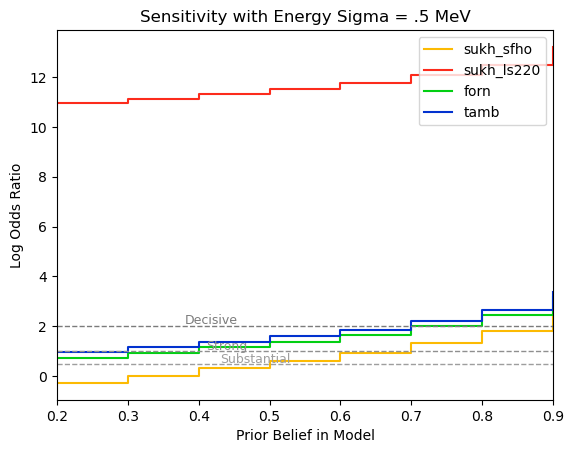

In [12]:
colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}
all_ratios_nh, all_ratios_ih = sigma_to_ratios(.5)

for i,mod_name in enumerate(names):
    if(mod_name!='zha'):
        means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
        means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
        if(means_nh[0]<means_ih[0]):
            plt.step(prior_list,means_nh,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
            ratio_mins[mod_name]=means_nh
        else:
            plt.step(prior_list,means_ih,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
            ratio_mins[mod_name]=means_ih
plt.legend(loc='upper right')


plt.title('Sensitivity with Energy Sigma = .5 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(.1,15)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')
plt.savefig('bayesian_energy_sig_2.png', dpi=300, bbox_inches='tight')

In [75]:
#from tabulate import tabulate

sigmas=[.5,1,2,3]
base_ratios_nh=np.load('sukh_sfho_nh_probs_1_iter.npz',allow_pickle=True)['arr_0']
base_ratios_ih=np.load('sukh_sfho_ih_probs_1_iter.npz',allow_pickle=True)['arr_0']
base_ratios_nh=base_ratios_nh.item()
base_ratios_ih=base_ratios_ih.item()

table_data = []
for i,sigma in enumerate(sigmas):
    ratios_nh,ratios_ih = sigma_to_ratios(sigma)
    
    delta_best_case = np.mean(ratios_nh['sukh_ls220'], axis=0)[3]-base_ratios_nh['sukh_ls220'][0][0][3]
    delta_rep = np.mean(ratios_ih['forn'], axis=0)[3]-base_ratios_ih['forn'][0][0][3]
    
    table_data.append([sigma, delta_best_case, delta_rep])
    
headers = ["sigma_E (MeV)", "delta ln(O_12) for best case", "delta ln(O_12) for representative case"]

print("Improvement to Log Odds Ratio from Different Energy Resolutions")
print(f"{'sigma_E (MeV)':<20} {'delta ln(O_12) for best case':<30} {'delta ln(O_12) for representative case':<30}")
print("-" * 80)
for row in table_data:
    print(f"{row[0]:<20} {row[1]:<30.6f} {row[2]:<30.6f}")

Improvement to Log Odds Ratio from Different Energy Resolutions
sigma_E (MeV)        delta ln(O_12) for best case   delta ln(O_12) for representative case
--------------------------------------------------------------------------------
0.5                  10.999472                      0.283808                      
1                    3.295598                       0.101754                      
2                    1.393611                       0.069687                      
3                    0.884297                       0.136488                      


In [30]:
np.min(all_ratios_ih['forn'], axis=0)

array([0.40546511, 0.61903921, 0.84729786, 1.09861229, 1.38629436,
       1.73460106, 2.19722458, 2.94443898])

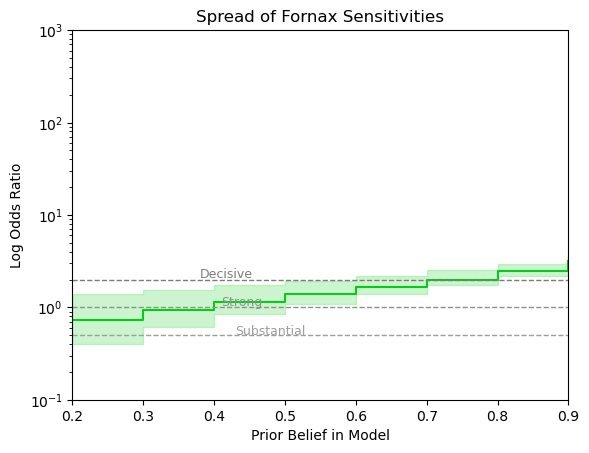

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}
all_ratios_nh, all_ratios_ih = sigma_to_ratios(.5)

for i,mod_name in enumerate(['forn']):
    means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
    means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
    if(means_nh[0]<means_ih[0]):
        plt.step(prior_list,means_nh,color='#fc2b1c',where='post',label=mod_name,linestyle=linestyles[i])
        plt.fill_between(prior_list,np.min(all_ratios_nh[mod_name], axis=0),np.max(all_ratios_nh[mod_name], axis=0),step='post',color='#fc2b1c',alpha=.2)
        ratio_mins[mod_name]=means_nh
    else:
        plt.step(prior_list,means_ih,color='#02cf13',where='post',label=mod_name,linestyle=linestyles[i])
        plt.fill_between(prior_list,np.min(all_ratios_ih[mod_name], axis=0),np.max(all_ratios_ih[mod_name], axis=0),step='post',color='#02cf13',alpha=.2)
        ratio_mins[mod_name]=means_ih



plt.title('Spread of Fornax Sensitivities')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(.1,10**3)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')
plt.savefig('bayesian_energy_spread_fornax.png', dpi=300, bbox_inches='tight')

In [41]:
len(all_ratios_nh['forn'])

25

Text(0.43, 0.51, 'Substantial')

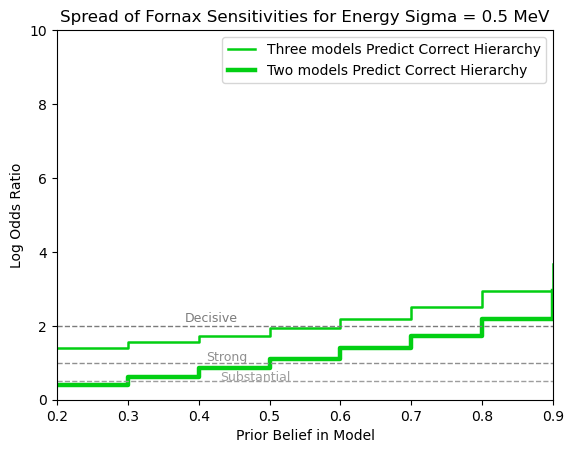

In [71]:
colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
} 
all_ratios_nh, all_ratios_ih = sigma_to_ratios(.5)
low=0
high=0
for i,ratios in enumerate(all_ratios_ih['forn']):
    if(ratios[0]<.5):
        low+=1
    else:
        high+=1
        
plt.step(prior_list,all_ratios_ih['forn'][4],color='#02cf13',where='post',linewidth=high/5,label='Three models Predict Correct Hierarchy')
plt.step(prior_list,all_ratios_ih['forn'][0],color='#02cf13',where='post',linewidth=low/5,label='Two models Predict Correct Hierarchy')


plt.legend()
plt.title('Spread of Fornax Sensitivities for Energy Sigma = 0.5 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(0,4)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
#plt.yscale('log')
#plt.savefig('bayesian_energy_spread_fornax_5mev.png', dpi=300, bbox_inches='tight')

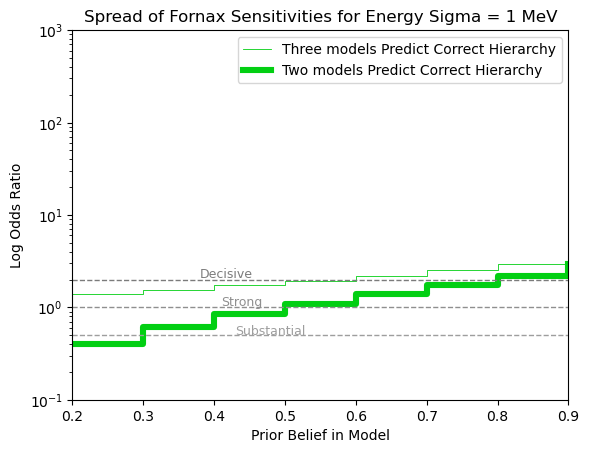

In [66]:
colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
} 
all_ratios_nh, all_ratios_ih = sigma_to_ratios(1)
low=0
high=0
for i,ratios in enumerate(all_ratios_ih['forn']):
    if(ratios[0]<.5):
        low+=1
    else:
        high+=1
        
plt.step(prior_list,all_ratios_ih['forn'][9],color='#02cf13',where='post',linewidth=high/5,label='Three models Predict Correct Hierarchy')
plt.step(prior_list,all_ratios_ih['forn'][0],color='#02cf13',where='post',linewidth=low/5,label='Two models Predict Correct Hierarchy')


plt.legend()
plt.title('Spread of Fornax Sensitivities for Energy Sigma = 1 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(.1,10**3)
plt.xlim(.2,.9)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')
plt.savefig('bayesian_energy_spread_fornax_1mev.png', dpi=300, bbox_inches='tight')

In [61]:
all_ratios_ih['forn']

[[0.4054651081081645,
  0.6190392084062236,
  0.8472978603872036,
  1.0986122886681096,
  1.3862943611198904,
  1.734601055388106,
  2.1972245773362196,
  2.9444389791664407],
 [0.4054651081081645,
  0.6190392084062236,
  0.8472978603872036,
  1.0986122886681096,
  1.3862943611198904,
  1.734601055388106,
  2.1972245773362196,
  2.9444389791664407],
 [0.4054651081081645,
  0.6190392084062236,
  0.8472978603872036,
  1.0986122886681096,
  1.3862943611198904,
  1.734601055388106,
  2.1972245773362196,
  2.9444389791664407],
 [0.4054651081081645,
  0.6190392084062236,
  0.8472978603872036,
  1.0986122886681096,
  1.3862943611198904,
  1.734601055388106,
  2.1972245773362196,
  2.9444389791664407],
 [0.4054651081081645,
  0.6190392084062236,
  0.8472978603872036,
  1.0986122886681096,
  1.3862943611198904,
  1.734601055388106,
  2.1972245773362196,
  2.9444389791664407],
 [0.40546510810849334,
  0.6190392084065329,
  0.8472978603874963,
  1.0986122886683876,
  1.386294361120156,
  1.734601